In [37]:
#requirements
import pandas as pd
from ast import literal_eval
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.linear_model import TheilSenRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#for BERT
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [2]:
def format_data():
    exp_data = pd.read_csv("Data/Rabani_expression_A+.csv")
    seq_data = pd.read_csv("Data/Rabani_oligos.csv")
    rbp_dict = pd.read_csv("Data/ZF_7N_PCBP2_vs_Adar-1.csv")[['Motif', 'Mean_RBP']].set_index('Motif').T.to_dict()

    #generate ER
    er_list = []
    seq_list = []
    token_list = []
    for ind,row in exp_data.iterrows():
        seq_id = exp_data.loc[ind, 'id'] 
        seq = seq_data.loc[seq_data['id'] == seq_id, 'Sequence'].values
        #see if sequence is in seq_data
        if seq.size !=0:
            er = (exp_data.loc[ind, '6h'] - exp_data.loc[ind, '1h'])/2
            er_list.append(er)
            seq_list.append(seq[0])
            token_list.append(tokenize(seq[0], rbp_dict))
            print(seq[0])
    df = pd.DataFrame({'Sequence':seq_list, 'Token':token_list,'Expression Rate':er_list})
    df.to_csv("Data/seq_er.csv")

In [24]:
#prepare the data
df = pd.read_csv("Data/seq_er.csv")
X = [literal_eval(s) for s in df['Token']]
Y = df['Expression Rate']

res = train_test_split(X, Y, 
                       train_size=0.8,
                       test_size=0.2,
                       random_state=1)
X_train, X_test, Y_train, Y_test = res 

In [38]:
model = TheilSenRegressor(random_state=0)

model.fit(X_train, Y_train)

TheilSenRegressor(random_state=0)

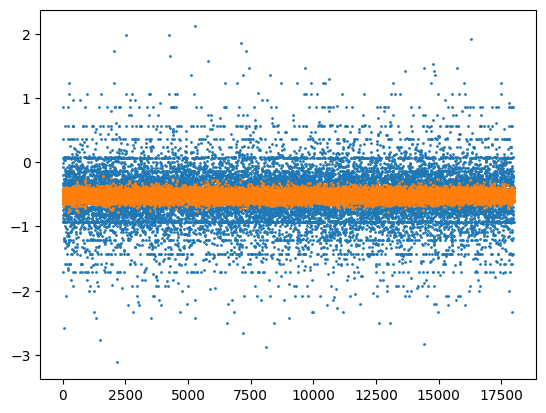

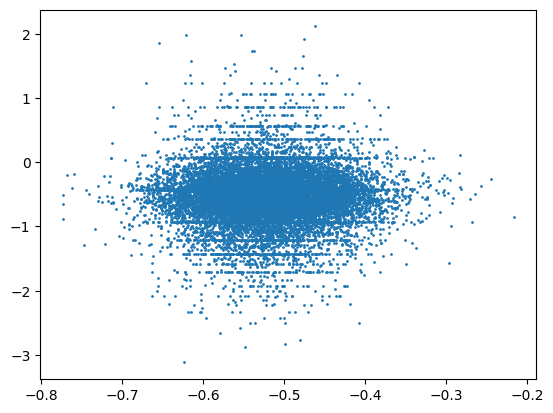

0.16957337272128714
0.4117928759962794


/Users/samuelwu/Desktop/2024/Fall/BU Med Lab/Seq Expression Pred/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/samuelwu/Desktop/2024/Fall/BU Med Lab/Seq Expression Pred/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
#plot mse
prediction = model.predict(X_test)
#plt.scatter(prediction, Y_test, s = 1)
x_array = range(len(Y_test))
plt.scatter(x_array, Y_test, s = 1)
plt.scatter(x_array, prediction, s = 1)
plt.show()

plt.scatter(prediction, Y_test, s = 1)
plt.show()

mse = mean_squared_error(y_true=Y_test, y_pred=prediction, squared=True)
rmse = mean_squared_error(y_true=Y_test, y_pred=prediction, squared=False)

print(mse)
print(rmse)

The linear regression didn't perform very well. Lets try this again but with a LLM trained to the sequence data. In order to have peak performance, we need to make a specific tokenizer for this model. The tokenizer should be able to identify key motifs in the sequence. 

In [41]:
#now, we try the same with with BERT
BASE_MODEL = "camembert-base"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)


/Users/samuelwu/Desktop/2024/Fall/BU Med Lab/Seq Expression Pred/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from datasets import Dataset

raw_train_ds = Dataset.from_json("Data/sentiments.train.jsonlines")
raw_val_ds = Dataset.from_json("Data/sentiments.validation.jsonlines")
raw_test_ds = Dataset.from_json("Data/sentiments.test.jsonlines")

# This line prints the description of train_ds
raw_train_ds, raw_val_ds, raw_test_ds

ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id", "uuid", "text", "score"])
   


Map: 100%|██████████| 660/660 [00:00<00:00, 2198.12 examples/s]


{'input_ids': [[5, 6703, 11092, 36, 1116, 21, 3, 152, 83, 83, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 84, 11, 41, 8, 583, 13, 2370, 1005, 27, 76, 11, 73, 283, 331, 9, 436, 504, 2104, 66, 24, 39, 874, 25803, 14, 39, 9319, 108, 9, 100, 49, 11, 73, 331, 771, 2957, 18, 11, 2002, 18, 11, 1251, 176, 27

Map: 100%|██████████| 142/142 [00:00<00:00, 2454.92 examples/s]


{'input_ids': [[5, 107, 11352, 7139, 152, 83, 83, 7664, 493, 27, 4650, 4433, 212, 366, 9, 9, 21, 9, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 6004, 17631, 16851, 6004, 17631, 16851, 6004, 17631, 16851, 6004, 17631, 16851, 6651, 274, 24, 27, 13, 6959, 5557, 23, 9867, 174, 109, 30, 1675, 1295, 83, 83, 83, 6767, 45, 6337, 21

Map: 100%|██████████| 142/142 [00:00<00:00, 2560.54 examples/s]

{'input_ids': [[5, 84, 2664, 8, 17, 21, 3, 243, 236, 18604, 8, 184, 7, 409, 1075, 8, 2599, 29, 16, 791, 20, 15591, 9, 1470, 227, 334, 106, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 3392, 22, 4792, 176, 2067, 619, 83, 15333, 18, 11, 7457, 15, 13, 8804, 7, 14, 32, 115, 9, 13, 21746, 9, 2607, 7, 19, 2486, 52, 11, 24049, 36, 476, 697, 83, 2036, 18, 11,

In [42]:
#load dataset
dataset = load_dataset('csv', data_files='Data/seq_er.csv')

X = df['Sequence']
Y = df['Expression Rate']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

ds = {"train": [], "validation": [], "test": []}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["id", "uuid", "text", "score"])

NameError: name 'raw_val_ds' is not defined

In [46]:
#metrics
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

training_args = TrainingArguments(
    output_dir="../models/camembert-fine-tuned-regression-2",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

/Users/samuelwu/Desktop/2024/Fall/BU Med Lab/Seq Expression Pred/venv/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
#Define the model
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [47]:
#Train the Model

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)
trainer.train()

  2%|▏         | 16/840 [00:28<15:58,  1.16s/it] 

KeyboardInterrupt: 